In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import plotly.express as plex
import seaborn as sns
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action = 'ignore', category=SettingWithCopyWarning)

from Model_functions import *

pd.set_option('display.max_columns', None, 'display.max.rows', None)

2022-09-14 17:18:30.585710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocessing

In [2]:
#Read the csv file created in Data_processing notebook with the full dataset
#on per game stats from 1980 till 2022

per_game_data = pd.read_csv("../data/MVP_per_game.csv")

#List of years we have data (ignoring current year)
years = [year for year in range(1980, 2022)]

In [3]:
#Split data to historical (all but last year's data) and final year data.  

test_year = 2022
historical_data = per_game_data[per_game_data["Year"] != test_year]
final_year_data = per_game_data[per_game_data["Year"] == test_year]

Using the Spearman technique (to include possible non-linear correlation between features) we get the correlation matrix between all features and plot them.

<AxesSubplot:>

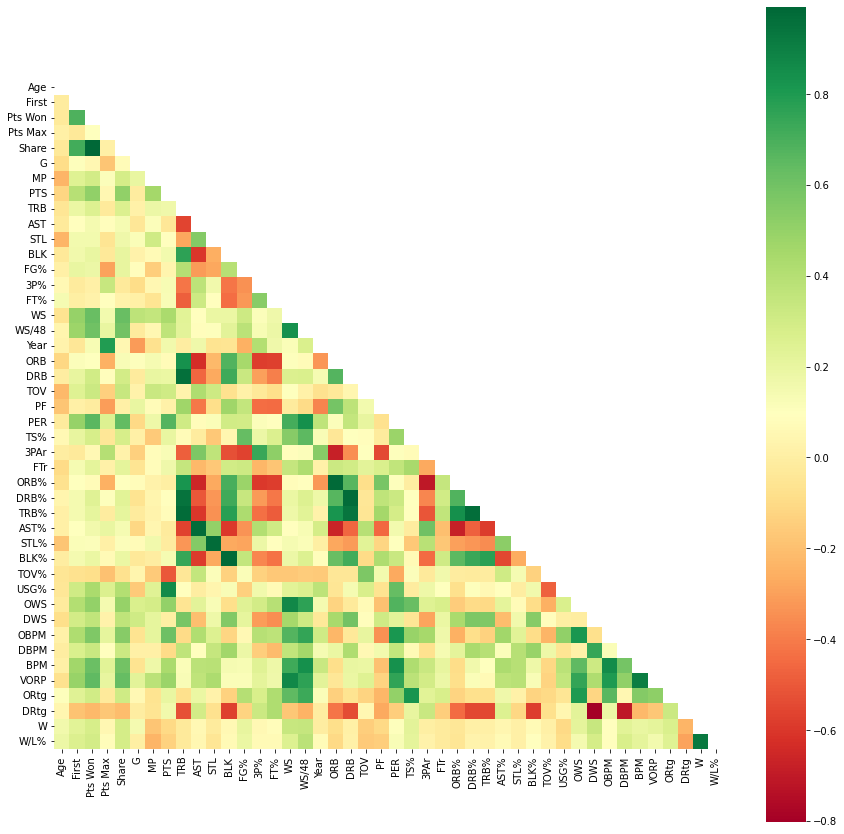

In [4]:
#correlations between all features
corr_matrix_spear = historical_data.corr(method='spearman')


# Getting the Upper Triangle of the co-relation matrix
mask = np.triu(corr_matrix_spear)

# using the upper triangle matrix as mask
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr_matrix_spear,
            annot=False,
            mask=mask,
            square = True,
            cmap = "RdYlGn",
            ax = ax
           )

In [5]:
#Pandas series with the correlation pairs
corr_pairs_spear = corr_matrix_spear.unstack().sort_values(kind = 'quicksort')


#Isolate the features with big correlations
large_corr = corr_pairs_spear[(np.abs(corr_pairs_spear) > 0.83) &
                                    (np.abs(corr_pairs_spear) != 1)
                                   ].drop_duplicates()

We split the data to historical and current. We use as current data only last year's (2021-2022). 

Removing some unnecessary columns and some very highly correlated features. 

In [6]:
#Dropping some initial columns

#Columns that are related to the target value but are not needed
pts_to_drop = ['First', 'Pts Won', 'Pts Max']

#Columns highly correlated to more advnced features we decide on keeping
cols_to_drop_init = ["TRB", "DRB", "ORB", "AST", "STL", "BLK", "W", "WS"]


#Remove above columns from both historical and final_year datasets
historical_data = historical_data.drop(pts_to_drop+cols_to_drop_init, axis=1)
final_year_data = final_year_data.drop(pts_to_drop+cols_to_drop_init, axis=1)

After removing some initial features based on their correlation score, we want to try and reduce the dimensionality even further. The way we go is to calculate the mutual information score between our target value ('Share') and all features. For that we first remove some columns containing more general information (name, team, season, etc) and use mutual_info_regression from sklern. Below we plot the features in descending order of their score.

In [7]:
#Features to drop for feature selection. They are not permanently removed.
drop_feat_selection = ['Player','Year', 'Age', 'Rank', 'Tm']

#Dataset used for feature selection
data_for_feature_selection = historical_data.drop(drop_feat_selection, axis=1)

In [8]:
scores_test = feature_importance(data_for_feature_selection)

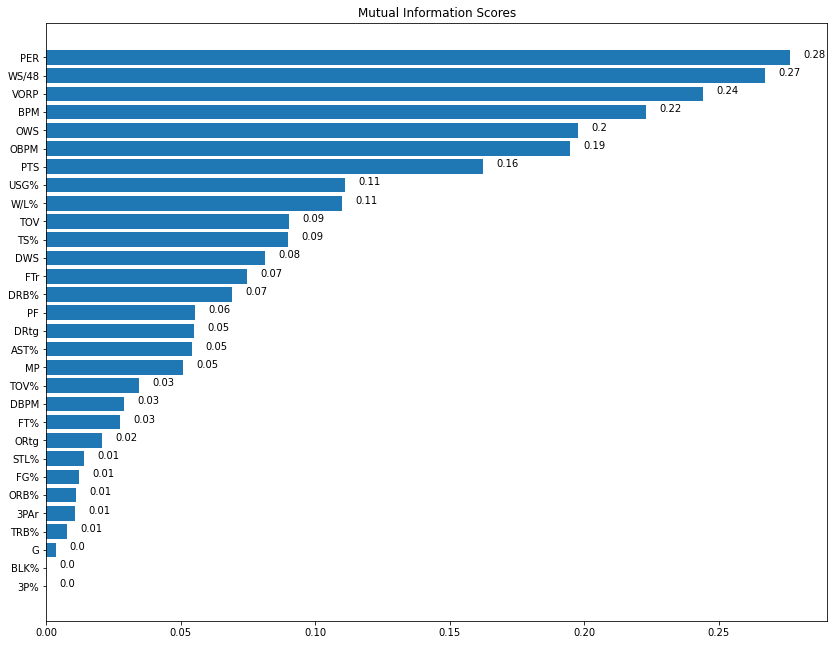

In [9]:
plot_scores(scores_test,
            figsize=(14,11),
            title = 'Mutual Information Scores'
           )

We decide to keep the top 14 features for our analysis.

In [10]:
#Keep about half the features based on mutual infofrmation scores

feats_to_keep = 14
feats, historical_data_reduced = sort_features(data_for_feature_selection,
                                                  feats_to_keep,
                                                  scores_test
                                                 )

Finally we define these separate datasets for both historical and current data.  

In [11]:
#Splitting the datasets into identification (includes names, teams, ages etc)
#and game stats datasets keeping only the important features.

#For historical data
id_data_hist = historical_data[['Rank', 'Player', 'Age', 'Tm', 'Year', 'Share']]
full_historical_data_reduced = id_data_hist.join(historical_data_reduced)


#For final_year data
id_data_pred = final_year_data[['Rank','Player', 'Age', 'Tm', 'Year', 'Share']]
data_pred_reduced = final_year_data[feats]
full_prediction_data_reduced = id_data_pred.join(data_pred_reduced)


## Exploring the current dataset

Here we plot some of the most important features based on our previous scores against MVP vote Share and we can spot some possible outliers. In general we can see the tendency that features like Value Over Replacement Player (VORP), Win Shares per 48 minutes (WS/48) and Player Efficiency Rating (PER) seem very pretty conclusive. Plotting the realation between the Win/Loss percentage and MVP vote Share we see that also it is very rare for a player from an average team to win it (most recent examples Russel Westbrook and Nikol Jokic in 2017 and 2022 respectively)

In [41]:
#Adding an extra column indicating if the player won the award or not for plotting reasons

MVP_races_data = historical_data.copy()
MVP_races_data['Result'] = np.where(MVP_races_data['Rank'] == '1', 'Yes', 'No')

In [42]:
#Isolating 4 main features we create a reduced dataset with only these statistics and the rankings
#of the MVP candidates in their year among them in these statistics. Since the number of candidates
#can vary from year to year we use the percentile ranking where a value closer to 1 indicates
#a high ranking 

basic_cols = ['Rank', 'Player', 'Age', 'Tm', 'Share', 'Year', 'Result']
main_feats = ['PER', 'VORP', 'WS/48', 'W/L%']
mvp_races = []

for year in list(set(per_game_data['Year'].values)):
    mvp_race = MVP_races_data[MVP_races_data['Year'] == year]
    mvp_races.append(mvp_race)
    
for i, race in enumerate(mvp_races):
    reduced = race[basic_cols + main_feats]
    for feat in main_feats:
        reduced[feat+'_rank'] = reduced[feat].rank(method='min', ascending=True, pct=True)
    mvp_races[i] = reduced
    
MVP_main_rankings = pd.concat(mvp_races)

# Below is the code for plotting scatter plots of the Share of NBA votes against VORP, PER, W/L%, and WS/48. We also include plots with the rank of the candidates in their year in those features. An additional plot against the Age of the candidates is included too. The figures are interactive and are saved as html files in the figure folder.

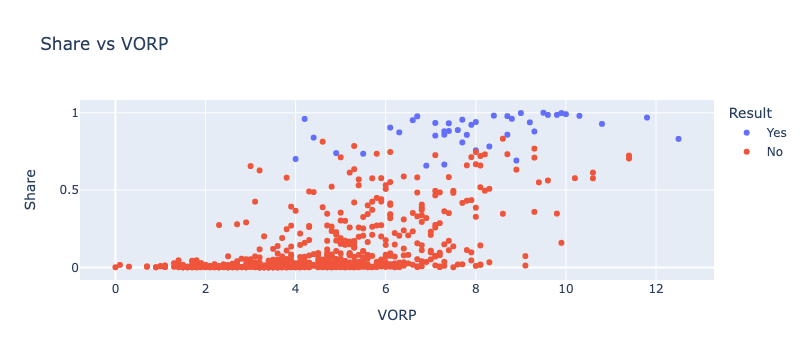

In [32]:
fig1 = plex.scatter(MVP_races_data,
                    y = 'Share',
                    x = 'VORP',
                    color='Result',
                    title = 'Share vs VORP',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig1.write_html('../figures/VORP.html')
fig1.show()

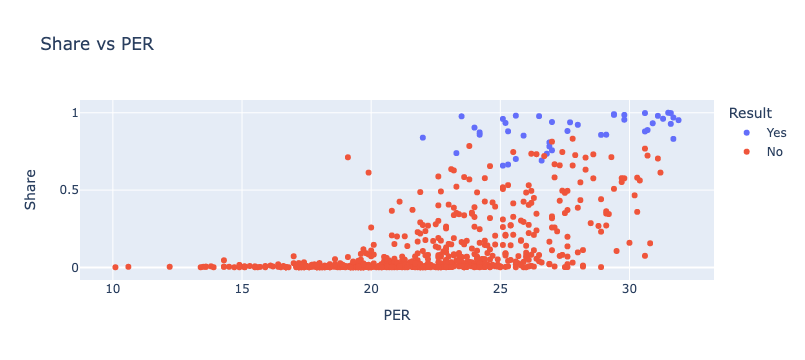

In [33]:
fig2 = plex.scatter(MVP_races_data,
                    y = 'Share',
                    x = 'PER',
                    color='Result',
                    title = 'Share vs PER',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig2.write_html('../figures/PER.html')
fig2.show()

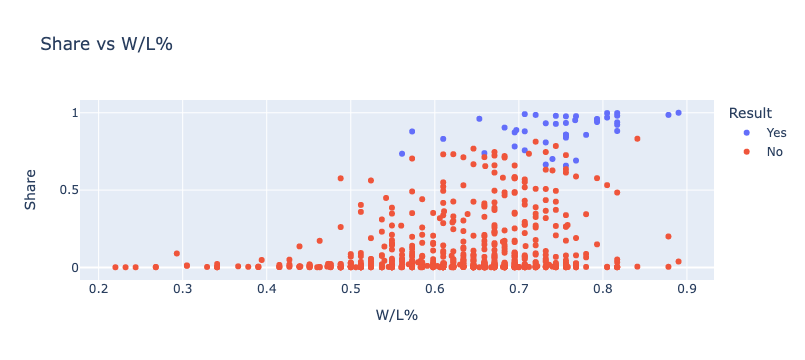

In [34]:
fig3 = plex.scatter(MVP_races_data,
                    y = 'Share',
                    x = 'W/L%',
                    color='Result',
                    title = 'Share vs W/L%',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig3.write_html('../figures/WL%.html')
fig3.show()

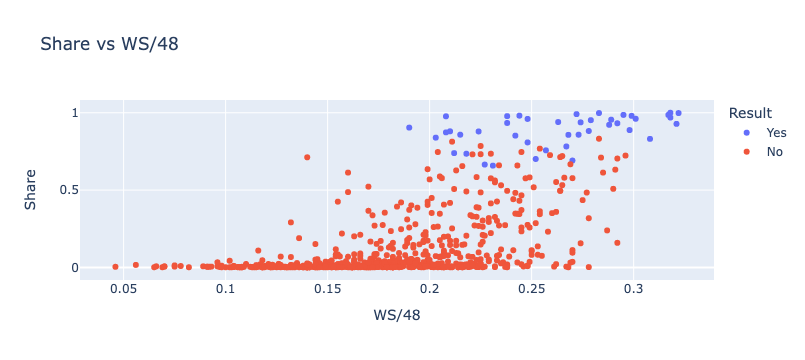

In [35]:
fig4 = plex.scatter(MVP_races_data,
                    y = 'Share',
                    x = 'WS/48',
                    color='Result',
                    title = 'Share vs WS/48',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig4.write_html('../figures/WS48.html')
fig4.show()

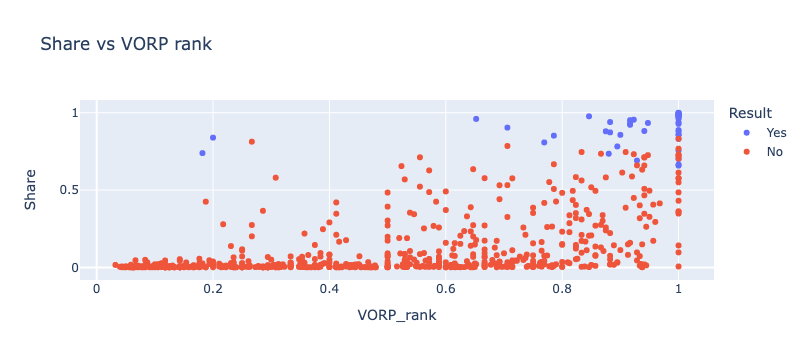

In [36]:
fig5 = plex.scatter(MVP_main_rankings,
                    y = 'Share',
                    x = 'VORP_rank',
                    color='Result',
                    title = 'Share vs VORP rank',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig5.write_html('../figures/VORP_rank.html')
fig5.show()

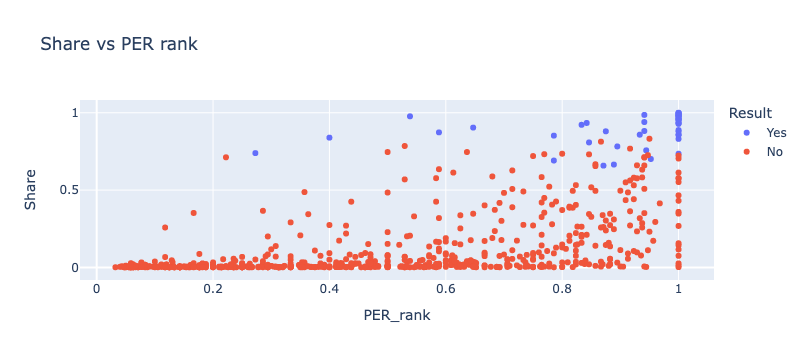

In [37]:
fig6 = plex.scatter(MVP_main_rankings,
                    y = 'Share',
                    x = 'PER_rank',
                    color='Result',
                    title = 'Share vs PER rank',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig6.write_html('../figures/PER_rank.html')
fig6.show()

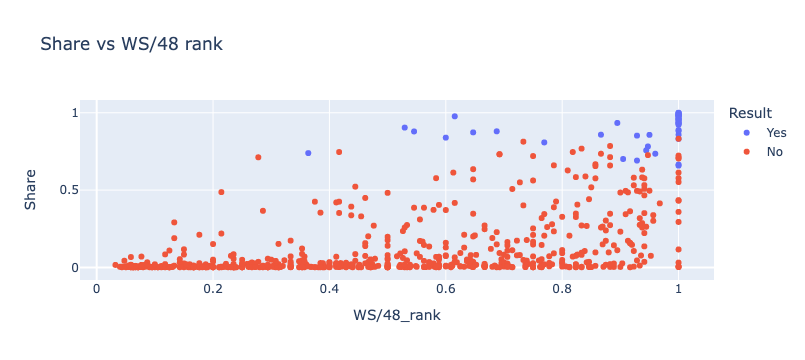

In [38]:
fig7 = plex.scatter(MVP_main_rankings,
                    y = 'Share',
                    x = 'WS/48_rank',
                    color='Result',
                    title = 'Share vs WS/48 rank',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig7.write_html('../figures/WS48_rank.html')
fig7.show()

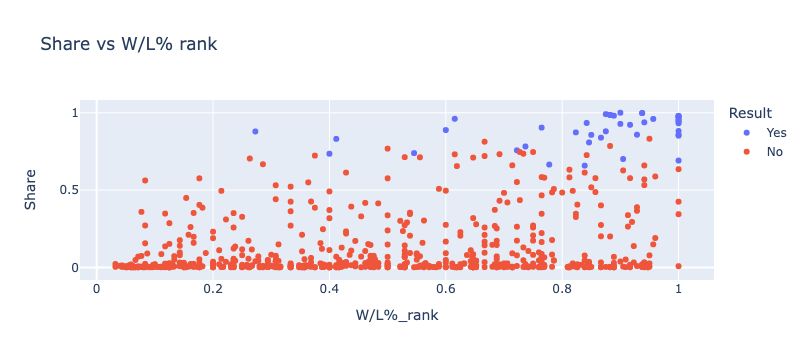

In [39]:
fig8 = plex.scatter(MVP_main_rankings,
                    y = 'Share',
                    x = 'W/L%_rank',
                    color='Result',
                    title = 'Share vs W/L% rank',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig8.write_html('../figures/WL%_rank.html')
fig8.show()

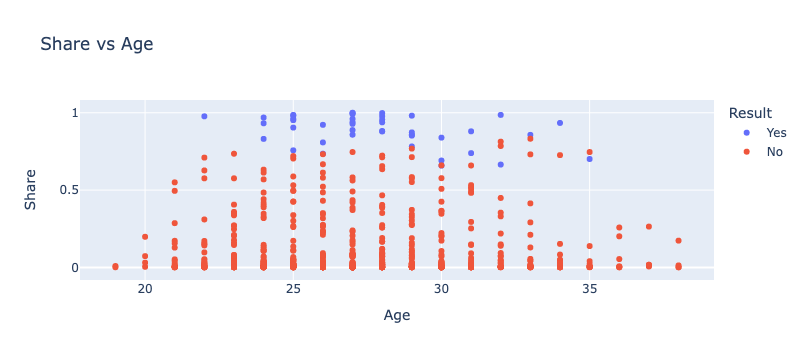

In [40]:
fig9 = plex.scatter(MVP_main_rankings,
                    y = 'Share',
                    x = 'Age',
                    color='Result',
                    title = 'Share vs Age',
                    hover_name='Player',
                    hover_data=['Year']
                   )
fig9.write_html('../figures/Age.html')
fig9.show()

## Training and predicting the past

We will use four different models trying first to predict the MVP for each year from 1980 till 2021 using the other years data for training and in the next section we predict the 2022 MVP using all previous data for training. The models we will use are:
1. Keras Neural Network
2. Random Forest Regression
3. Gradient Boosting Regressot (from XGBoost)

The hyperparameters used here have been tuned in the relevant notebook in this folder

### Neural Network

In [30]:
DNN_model = keras_model(n1=50,
                       optimizer=keras.optimizers.SGD,
                       learn_rate=0.25,
                       dropout=0.13)
    
model_DNN, mvp_race_lst_DNN, summary_DNN = run_model(DNN_model,
                                                  full_historical_data_reduced,
                                                  years,
                                                  scaling = True,
                                                  NN = True,
                                                  epochs = 60,
                                                  batch_size= 60
                                                 )

mse_DNN = np.mean(summary_DNN['MSE score'].values)
R2_DNN = np.mean(summary_DNN['R2 score'].values)
accuracy_DNN = (summary_DNN['Result'] == 'Right').sum() / len(years)

1/1 [==============================] - 0s 23ms/step


In [53]:
summary_DNN

,Year,Actual MVP,Predicted MVP,MSE score,R2 score,Result
0,1980,Kareem Abdul-Jabbar,Julius Erving,0.030045,0.256461,Wrong
1,1981,Julius Erving,Julius Erving,0.009311,0.669490,Right
2,1982,Moses Malone,Larry Bird,0.010339,0.689330,Wrong
3,1983,Moses Malone,Moses Malone,0.005275,0.894547,Right
4,1984,Larry Bird,Larry Bird,0.023161,0.563777,Right
5,1985,Larry Bird,Larry Bird,0.004349,0.900954,Right
6,1986,Larry Bird,Larry Bird,0.015126,0.743227,Right
7,1987,Magic Johnson,Magic Johnson,0.013514,0.790044,Right
8,1988,Michael Jordan,Michael Jordan,0.007386,0.892785,Right
9,1989,Magic Johnson,Magic Johnson,0.003451,0.937381,Right


In [52]:
print(mse_DNN)
print(R2_DNN)
print(accuracy_DNN)

0.012015143227349371
0.8103009196919922
0.7619047619047619


### Random Forest Regressor

In [54]:
RF_model = RandomForestRegressor(n_estimators = 46,
                                max_depth = 17,
                                min_samples_leaf = 3,
                                min_samples_split = 2,
                                random_state = 42
                                )

model_RF, mvp_race_lst_RF, summary_RF = run_model(RF_model,
                                                  full_historical_data_reduced,
                                                  years
                                                 )
    
mse_RF = np.mean(summary_RF['MSE score'].values)
R2_RF = np.mean(summary_RF['R2 score'].values)
accuracy_RF = (summary_RF['Result'] == 'Right').sum() / len(years)

In [55]:
summary_RF

,Year,Actual MVP,Predicted MVP,MSE score,R2 score,Result
0,1980,Kareem Abdul-Jabbar,Julius Erving,0.024600,0.391218,Wrong
1,1981,Julius Erving,Julius Erving,0.009146,0.675346,Right
2,1982,Moses Malone,Larry Bird,0.018380,0.447726,Wrong
3,1983,Moses Malone,Moses Malone,0.025662,0.486999,Right
4,1984,Larry Bird,Larry Bird,0.030668,0.422395,Right
5,1985,Larry Bird,Larry Bird,0.006659,0.848346,Right
6,1986,Larry Bird,Larry Bird,0.017887,0.696345,Right
7,1987,Magic Johnson,Magic Johnson,0.012817,0.800873,Right
8,1988,Michael Jordan,Michael Jordan,0.018065,0.737760,Right
9,1989,Magic Johnson,Michael Jordan,0.007979,0.855237,Wrong


In [56]:
print(mse_RF)
print(R2_RF)
print(accuracy_RF)

0.026532008949198372
0.612339312698178
0.6904761904761905


In [26]:
feat_importance_RF = []
cols = x_train_pg.columns.values
for model in model_RF:
    feat_scores = model.feature_importances_
    feat_importance_RF.append(feat_scores)
    
feat_df_RF = pd.DataFrame(feat_importance_RF, columns=cols)
feat_df_avg_RF = feat_df_RF.mean()
feat_df_avg_RF.sort_values(ascending = False)

VORP     0.277669
PER      0.199178
W/L%     0.173191
WS/48    0.059696
OBPM     0.045832
TOV      0.044722
PTS      0.036532
DWS      0.036472
BPM      0.030057
OWS      0.020803
USG%     0.020329
FTr      0.020115
DRB%     0.020002
TS%      0.015403
dtype: float64

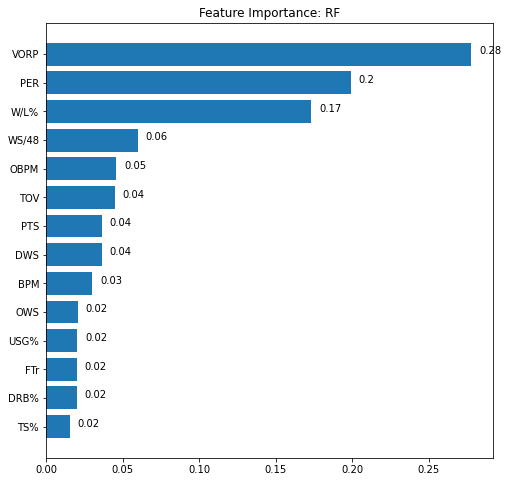

In [27]:
plot_scores(feat_df_avg_RF,
            figsize=(8,8),
            title = 'Feature Importance: RF'
            )

In [103]:
XGB_model = XGBRegressor(n_estimators = 43,
                        learning_rate = 0.16,
                        max_depth = 3
                        )
            
model_XGB, mvp_race_lst_XGB, summary_XGB = run_model(XGB_model,
                                                     full_historical_data_reduced,
                                                     years
                                                    )
    
mse_XGB = np.mean(summary_XGB['MSE score'].values)
R2_XGB = np.mean(summary_XGB['R2 score'].values)
accuracy_XGB = (summary_XGB['Result'] == 'Right').sum() / len(years)

In [104]:
summary_XGB

,Year,Actual MVP,Predicted MVP,MSE score,R2 score,Result
0,1980,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,0.017850,0.558262,Right
1,1981,Julius Erving,Julius Erving,0.009834,0.650928,Right
2,1982,Moses Malone,Larry Bird,0.016914,0.491783,Wrong
3,1983,Moses Malone,Moses Malone,0.022170,0.556808,Right
4,1984,Larry Bird,Larry Bird,0.030856,0.418862,Right
5,1985,Larry Bird,Larry Bird,0.006349,0.855412,Right
6,1986,Larry Bird,Larry Bird,0.013127,0.777158,Right
7,1987,Magic Johnson,Magic Johnson,0.017854,0.722612,Right
8,1988,Michael Jordan,Michael Jordan,0.016796,0.756177,Right
9,1989,Magic Johnson,Magic Johnson,0.007763,0.859157,Right


In [105]:
print(mse_XGB)
print(R2_XGB)
print(accuracy_XGB)

0.027552619940149743
0.5996407568999848
0.7619047619047619


In [107]:
feat_importance_XGB = []
cols = x_train_unsc.columns.values
for model in model_XGB:
    feat_scores = model.feature_importances_
    feat_importance_XGB.append(feat_scores)
    
feat_df_XGB = pd.DataFrame(feat_importance_XGB, columns=cols)
feat_df_avg_XGB = feat_df_XGB.mean()
feat_df_avg_XGB.sort_values(ascending = False)

VORP     0.406552
PER      0.197238
W/L%     0.095313
WS/48    0.043573
TOV      0.039412
USG%     0.036823
DWS      0.032618
OBPM     0.032189
BPM      0.030020
PTS      0.025963
OWS      0.022251
FTr      0.014119
DRB%     0.012017
TS%      0.011912
dtype: float32

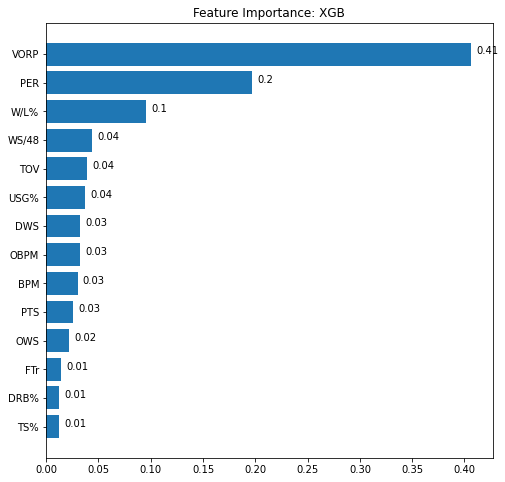

In [108]:
plot_scores(feat_df_avg_XGB,
            figsize=(8,8),
            title = 'Feature Importance: XGB'
            )

## Predictions

In [143]:
best_DNN = keras_model(n1=50,
                      optimizer=keras.optimizers.SGD,
                      learn_rate=0.25,
                      dropout=0.13
                     )

x_train_all, y_train, x_test_all, y_test = data_prep(full_historical_data_reduced,
                                             full_prediction_data_reduced,
                                             feats,
                                             scaling=True
                                            )

x_train = x_train_all.drop(['Rank', 'Player', 'Tm', 'Year', 'Age'], axis=1)
x_test = x_test_all.drop(['Rank', 'Player', 'Tm', 'Year', 'Age'], axis=1)

best_NN.fit(x_train, y_train, epochs=60, batch_size=60, verbose=0)

In [144]:
rank = x_test_all['Rank'].tolist()
names = x_test_all['Player'].tolist()
preds_NN = best_NN.predict(x_test, verbose=0)
preds_NN = list(np.concatenate(preds_NN))
y_test_lst = y_test.tolist()

print("Mean squared error: %.3f" % mean_squared_error(y_test_lst, preds_NN))
print('R2 score: %.3f' % r2_score(y_test_lst, preds_NN))

ds_pred_NN = {'Actual Rank': rank,
                 'Player': names,
                 'Actual Share': y_test_lst,
                 'NN Share': preds_NN
                }

df_pred_NN = pd.DataFrame(ds_pred_NN).sort_values('NN Share', ascending=False, ignore_index=True)

Mean squared error: 0.019
R2 score: 0.801


In [145]:
df_pred_NN

,Actual Rank,Player,Actual Share,NN Share
0,1,Nikola Jokić,0.875,0.721315
1,3,Giannis Antetokounmpo,0.595,0.523169
2,2,Joel Embiid,0.706,0.399739
3,5,Luka Dončić,0.146,0.310845
4,6,Jayson Tatum,0.043,0.138778
5,7,Ja Morant,0.010,0.110320
6,8,Stephen Curry,0.004,0.078326
7,10T,LeBron James,0.001,0.038829
8,4,Devin Booker,0.216,0.023057
9,9,Chris Paul,0.002,0.022220


In [121]:
x_train_all_unsc, y_train_all_unsc, x_test_all_unsc, y_test_all_unsc = data_prep(
                                                                full_historical_data_reduced,
                                                                full_prediction_data_reduced,
                                                                feats,
                                                                scaling=False
                                                                )

x_train_unsc = x_train_all_unsc.drop(['Rank', 'Player', 'Tm', 'Year', 'Age'], axis=1)
x_test_unsc = x_test_all_unsc.drop(['Rank', 'Player', 'Tm', 'Year', 'Age'], axis=1)

In [146]:
best_RF = RandomForestRegressor(n_estimators=46,
                                min_samples_split=2,
                                min_samples_leaf=3,
                                max_depth=17,
                                random_state=42
                               )


best_RF.fit(x_train_unsc, y_train_unsc)

rank = x_test_all_unsc['Rank'].tolist()
names = x_test_all_unsc['Player'].tolist()
preds_RF = best_RF.predict(x_test_unsc)
preds_RF = preds_RF.tolist()
y_test_RF = y_test_unsc.tolist()
print("Mean squared error: %.3f" % mean_squared_error(y_test_RF, preds_RF))
print('R2 score: %.3f' % r2_score(y_test_RF, preds_RF))

ds_pred_RF = {'Actual Rank': rank,
                 'Player': names,
                 'Actual Share': y_test_RF,
                 'RF Share': preds_RF
                }

df_pred_RF = pd.DataFrame(ds_pred_RF).sort_values('RF Share', ascending=False, ignore_index=True)

Mean squared error: 0.031
R2 score: 0.687


In [147]:
df_pred_RF

,Actual Rank,Player,Actual Share,RF Share
0,1,Nikola Jokić,0.875,0.558955
1,3,Giannis Antetokounmpo,0.595,0.507928
2,2,Joel Embiid,0.706,0.377068
3,5,Luka Dončić,0.146,0.280067
4,7,Ja Morant,0.010,0.209193
5,10T,LeBron James,0.001,0.177598
6,6,Jayson Tatum,0.043,0.134075
7,4,Devin Booker,0.216,0.088888
8,8,Stephen Curry,0.004,0.056599
9,10T,DeMar DeRozan,0.001,0.055698


In [148]:
best_XGB = XGBRegressor(n_estimators=43,
                        max_depth=3,
                        learning_rate = 0.16
                        )


best_XGB.fit(x_train_unsc, y_train_unsc)

rank = x_test_all_unsc['Rank'].tolist()
names = x_test_all_unsc['Player'].tolist()
preds_XGB = best_XGB.predict(x_test_unsc)
preds_XGB = preds_XGB.tolist()
y_test_XGB = y_test_unsc.tolist()
print("Mean squared error: %.3f" % mean_squared_error(y_test_XGB, preds_XGB))
print('R2 score: %.3f' % r2_score(y_test_XGB, preds_XGB))

ds_pred_XGB = {'Actual Rank': rank,
                 'Player': names,
                 'Actual Share': y_test_XGB,
                 'XGB Share': preds_XGB
                }

df_pred_XGB = pd.DataFrame(ds_pred_XGB).sort_values('XGB Share', ascending=False, ignore_index=True)

Mean squared error: 0.023
R2 score: 0.766


In [149]:
df_pred_XGB

,Actual Rank,Player,Actual Share,XGB Share
0,3,Giannis Antetokounmpo,0.595,0.659588
1,1,Nikola Jokić,0.875,0.598019
2,2,Joel Embiid,0.706,0.485149
3,5,Luka Dončić,0.146,0.346344
4,7,Ja Morant,0.010,0.234683
5,4,Devin Booker,0.216,0.174804
6,10T,LeBron James,0.001,0.151860
7,6,Jayson Tatum,0.043,0.094464
8,8,Stephen Curry,0.004,0.053264
9,10T,DeMar DeRozan,0.001,0.040206


In [150]:
full_summary_pred = {'Model': ['Neural Network', 'Random Forest', 'XGBoost'],
                     'Winner': [df_pred_NN.loc[0,'Player'],df_pred_RF.loc[0,'Player'],df_pred_XGB.loc[0,'Player']],
                     '1st Share': [df_pred_NN.loc[0,'NN Share'],df_pred_RF.loc[0,'RF Share'],df_pred_XGB.loc[0,'XGB Share']],
                     'Second': [df_pred_NN.loc[1,'Player'],df_pred_RF.loc[1,'Player'],df_pred_XGB.loc[1,'Player']],
                     '2nd Share': [df_pred_NN.loc[1,'NN Share'],df_pred_RF.loc[1,'RF Share'],df_pred_XGB.loc[1,'XGB Share']],
                     'Third': [df_pred_NN.loc[2,'Player'],df_pred_RF.loc[2,'Player'],df_pred_XGB.loc[2,'Player']],
                     '3rd Share': [df_pred_NN.loc[2,'NN Share'],df_pred_RF.loc[2,'RF Share'],df_pred_XGB.loc[2,'XGB Share']]
                    }

In [151]:
full_summary_pred_df = pd.DataFrame(full_summary_pred)
full_summary_pred_df

,Model,Winner,1st Share,Second,2nd Share,Third,3rd Share
0,Neural Network,Nikola Jokić,0.721315,Giannis Antetokounmpo,0.523169,Joel Embiid,0.399739
1,Random Forest,Nikola Jokić,0.558955,Giannis Antetokounmpo,0.507928,Joel Embiid,0.377068
2,XGBoost,Giannis Antetokounmpo,0.659588,Nikola Jokić,0.598019,Joel Embiid,0.485149


In [163]:
full_results = pd.merge(df_pred_NN, pd.merge(df_pred_RF, df_pred_XGB, on = ['Player']), on=['Player'])
to_drop = [x for x in full_results.columns.values if x.endswith('_y') or x.endswith('_x')]
full_results.drop(to_drop, axis=1, inplace=True)

full_preds = full_results.copy()[['NN Share', 'RF Share', 'XGB Share']]
full_preds.mean(axis=1)

full_results['Average Share'] = full_preds.mean(axis=1)

full_results.sort_values('Average Share', ascending=False, ignore_index=True, inplace=True)

In [164]:
full_results

,Actual Rank,Player,Actual Share,NN Share,RF Share,XGB Share,Average Share
0,1,Nikola Jokić,0.875,0.721315,0.558955,0.598019,0.626096
1,3,Giannis Antetokounmpo,0.595,0.523169,0.507928,0.659588,0.563562
2,2,Joel Embiid,0.706,0.399739,0.377068,0.485149,0.420652
3,5,Luka Dončić,0.146,0.310845,0.280067,0.346344,0.312419
4,7,Ja Morant,0.010,0.110320,0.209193,0.234683,0.184732
5,10T,LeBron James,0.001,0.038829,0.177598,0.151860,0.122762
6,6,Jayson Tatum,0.043,0.138778,0.134075,0.094464,0.122439
7,4,Devin Booker,0.216,0.023057,0.088888,0.174804,0.095583
8,8,Stephen Curry,0.004,0.078326,0.056599,0.053264,0.062730
9,10T,DeMar DeRozan,0.001,0.009420,0.055698,0.040206,0.035108
